<a href="https://colab.research.google.com/github/AharonRemez/Emotion-Classification-Using-Convolutional-Neural-Networks-CNN-1/blob/main/feeling_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset
!unzip emotion-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Sad/0a12a7e998fa7abde73e79ce2a74477bdc6f5dd010da05231f4c3330.jpg  
  inflating: dataset/Sad/0a1370fc7e34586d5f134694c9d1e79ed4cce9e59684077ae5061db8.png  
  inflating: dataset/Sad/0a14abb2a25753914205e88e870054918de36219552002f3144b8455.jpg  
  inflating: dataset/Sad/0a15eede4e05e13f70f6540c4167282f9a488cc318005c8693c49433.jpg  
  inflating: dataset/Sad/0a163aa46984ad37b58aa6b8175dca9b1007a3066099d18f4dda6f78.jpg  
  inflating: dataset/Sad/0a1833eb2427bd8c1ddd3b9c020c6233a3671763e21b1e08b5afa41f.jpg  
  inflating: dataset/Sad/0a19842e87935fbd2c45a7042e4bb8d1d3816476e8a6b7e8f41205d8.jpg  
  inflating: dataset/Sad/0a1d613237e9af295213c61e1c2b9d7fd211fad638c522afb9548901.jpg  
  inflating: dataset/Sad/0a1d86074a08f9bf55858cf90eaaee6f1e0362d97f08cbaa161e30e0.jpg  
  inflating: dataset/Sad/0a22b8d3b2fbcbebb6a4be7dad0a37b92983e8afe42b4d48cded4e45.jpg  
  inflating: dataset/Sad/0a285a2a07f0f8daaa0a821e30ad2e558ddc18f2589a

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from pathlib import Path
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
data_dir = Path('/content/dataset')
x = 0
CLASS_NAMES = []
for expression in os.listdir(data_dir):
  # Use the / operator for joining paths
  expression_path = data_dir / expression
  print(f'{expression}\t\t=> {len(os.listdir(expression_path))}')
  x += len(os.listdir(expression_path))
  CLASS_NAMES.append(expression)
print(f'Total Images : {x}')
print(f'Class Image => {CLASS_NAMES}')

Happy		=> 3740
Angry		=> 1313
Neutral		=> 4027
Sad		=> 3934
Surprise		=> 1234
Total Images : 14248
Class Image => ['Happy', 'Angry', 'Neutral', 'Sad', 'Surprise']


In [ ]:
# prompt: Ahegao מהדאטה תמחק לי את תיקיית

!rm -rf /content/dataset/Ahegao


In [ ]:
CONFIGURATION = {
    'VALIDATION' : 0.2,
    'BATCH_SIZE' : 64,
    'IM_SIZE' : 224,
    'LEARNING_RATE' : 1e-3,
    'N_EPOCHS' : 50,
    'DROPOUT_RATE' : 0.25,
    'REGULARIZATION_RATE' : 0.01,
    'N_FILTERS' : 6,
    'KERNEL_SIZE' : 5,
    'N_STRIDES' : 1,
    'POOL_SIZE' : 2,
    'N_DENSE_1' : 128,
    'N_DENSE_2' : 32,
    'NUM_CLASSES' : len(CLASS_NAMES),
    'CLASS_NAMES' : CLASS_NAMES,
}

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 100,
    subset = "training",
    validation_split = CONFIGURATION['VALIDATION']
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 200,
    subset = "validation",
    validation_split = CONFIGURATION['VALIDATION']
)

Found 14248 files belonging to 5 classes.
Using 11399 files for training.
Found 14248 files belonging to 5 classes.
Using 2849 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Happy', 'Angry', 'Neutral', 'Sad', 'Surprise']


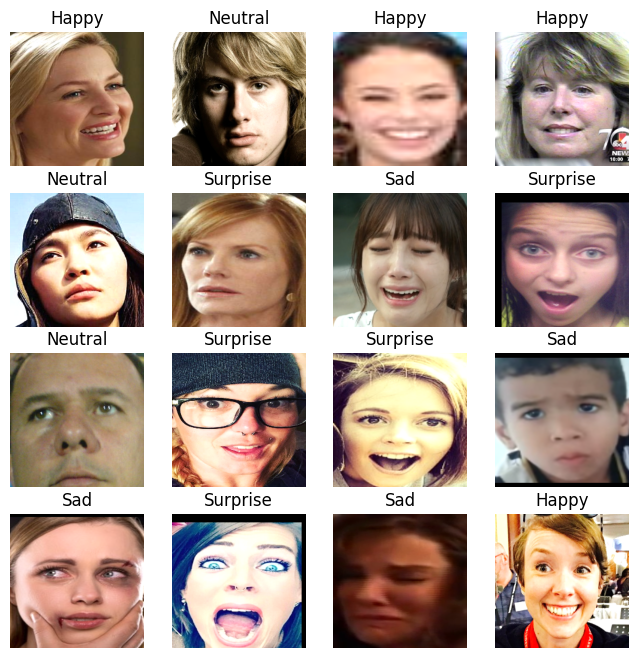

In [ ]:
plt.figure(figsize = (8,8))
for image,label in train_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image[i]/225)
    plt.title(CONFIGURATION['CLASS_NAMES'][tf.argmax(label[i], axis=0).numpy()])
    plt.axis('off')
plt.show()

In [ ]:
for image_batch, labels_batch in train_ds: #train data
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64, 5)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
backbone = tf.keras.applications.EfficientNetV2B0(
    input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3),
    include_top=False,
    weights='imagenet'
)
backbone.trainable = False

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    backbone,
    layers.Flatten(),
    layers.Dropout(0.50),
    layers.Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax')
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │         313,605 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,232,917 (23.78 MB)

 Trainable params: 313,605 (1.20 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam


loss_func = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = 'accuracy')]


checkpoint_callback = ModelCheckpoint(
    'best_weights.keras',
    monitor = 'val_accuracy',
    save_best_only = True
)
early_stopping = EarlyStopping(monitor='val_accuracy',
#                                min_delta=0.01,
                               restore_best_weights = True,
                               patience=3)

model.compile(
    optimizer = Adam(learning_rate = 1e-2),
    loss = loss_func,
    metrics = metrics
)
history = model.fit(
    train_ds, validation_data = val_ds,
    epochs = CONFIGURATION['N_EPOCHS'], verbose = 1, callbacks = [early_stopping]
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 167ms/step - accuracy: 0.8820 - loss: 10.3525 - val_accuracy: 0.9140 - val_loss: 10.1431
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.8885 - loss: 10.1357 - val_accuracy: 0.9245 - val_loss: 9.7249
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.8773 - loss: 10.9545 - val_accuracy: 0.9231 - val_loss: 10.6167
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.8923 - loss: 10.1648 - val_accuracy: 0.9172 - val_loss: 10.3650
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8927 - loss: 10.3668 - val_accuracy: 0.9221 - val_loss: 10.8729


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


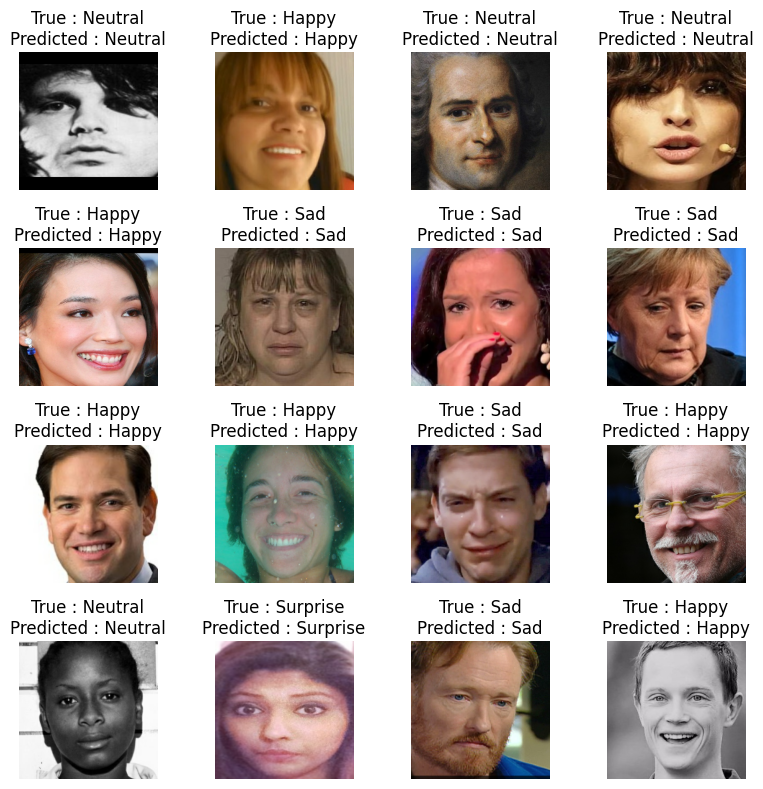

In [ ]:
plt.figure(figsize=(8,8))
for image,label in train_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title(f'True : {CLASS_NAMES[tf.argmax(label[i], axis=0).numpy()]}\nPredicted : {CLASS_NAMES[tf.argmax(model.predict(tf.expand_dims(image[i], axis=0)), axis=1).numpy()[0]]}')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

Saving מאוכזב.jpg to מאוכזב.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
This image most likely belongs to Sad with a 40.46 percent confidence.


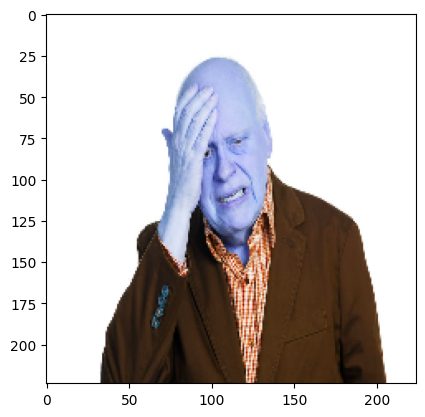

In [ ]:
from google.colab import files
import cv2

uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = cv2.imread(path)
  img = cv2.resize(img,(224,224))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  plt.imshow(img)


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━

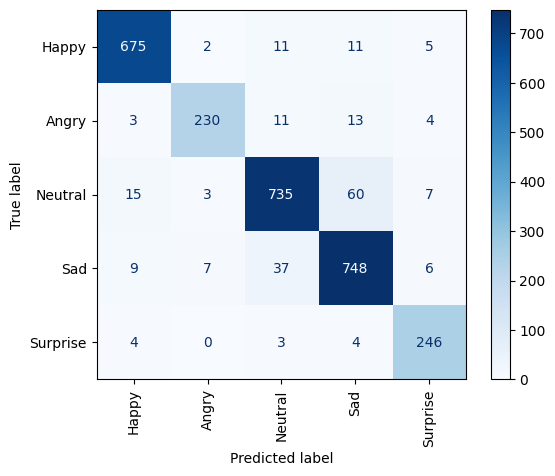

In [ ]:
# prompt: תכין לי ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
  predictions = model.predict(images)
  for i in range(images.shape[0]):
    y_true.append(np.argmax(labels[i]))
    y_pred.append(np.argmax(predictions[i]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()
